# Investigating impact of different window size on model performance in classifying collaboration quality
This source code is for LAK 23 paper with title "Impact of window size on the generalizability of collaboration quality
estimation models developed using Multimodal Learning Analytics" 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import accuracy_score,cohen_kappa_score,precision_score,recall_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate,KFold, GridSearchCV, cross_val_score, LeaveOneGroupOut
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
from numpy import mean,nanmean
from numpy import std,nanstd

from sklearn.metrics import make_scorer, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

In [39]:
context_data = pd.read_csv('../CoTrack_dataset_2022_features_v2.csv')
context_data = context_data.loc[context_data.session.isin([91,98,99])]

def addContextData(df):
    context = {}
    new_df_list = [] 
    final_feature_cols = set(feature_cols).intersection(set(df.columns.to_list())) - set(['group'])
    data_con = pd.get_dummies(context_data[context_cols])  
    context_dummy_cols = data_con.columns
    for group in df.group.unique(): 
        data_con_grp = data_con.loc[context_data['group'] == group]
        data_fet_grp = df.loc[df['group'] == group]      
        data_con_grp = data_con_grp.reset_index()
        data_con_grp = data_con_grp[data_con_grp.columns.difference(['index'])]   
        res = data_con_grp.iloc[0,:].to_dict()  
        for col in res.keys():
            data_fet_grp[col] = res[col]  
        new_df_list.append(data_fet_grp)   
    new_df = pd.concat(new_df_list)   
    
    total_cols = list(final_feature_cols) + list(context_dummy_cols)  
    scaler = StandardScaler()
    
    #data_with_context = new_df[total_cols]
    #scaled_data = scaler.fit_transform(data_with_context)
    
    data_without_context = df[list(final_feature_cols)]
    
    scaled_data = scaler.fit_transform(data_without_context)
    
    return pd.DataFrame(scaled_data,columns = data_without_context.columns)


In [2]:
# Columns for features and labels

feature_cols = ['user_add_mean', 'user_add_sd', 'user_del_mean', 'user_del_sd',
       'user_self_mean', 'user_self_sd', 'user_speak_mean', 'user_speak_sd',
        'user_turns_mean',
        'user_turns_sd', 'user_us_mean', 'user_us_sd', 
        'user_yes_mean', 'user_yes_sd'] + ['group']

context_cols = ['language',
       'learning_design', 'time', 'students', 'class', 'teacher', 'subject']

label_cols = ['ARG', 'CF', 'CO', 'CQ', 'ITO', 'KE', 'SMU', 'STR']

In [10]:
# features to remove from processed dataset
cols_diff = ['index','frame','group','session','write_text','user_speech','students']

In [13]:
# To binarize the rating scores of collaboration quality and its dimensions

def binarize_dim(v):  
    if v/2 > 0:
        return 1
    else:
        return 0
    
def binarize_cq(v):  
    if v/7 > .5:
        return 1
    else:
        return 0    

def binarize(data):
    data['CQ_bi'] = data['CQ'].map(binarize_dim)
    data['ARG_bi'] = data['ARG'].map(binarize_dim)
    data['CO_bi'] = data['CO'].map(binarize_dim)
    data['SMU_bi'] = data['SMU'].map(binarize_dim)
    data['KE_bi'] = data['KE'].map(binarize_dim)
    data['STR_bi'] = data['STR'].map(binarize_dim)
    data['ITO_bi'] = data['ITO'].map(binarize_median)
    data['CF_bi'] = data['CF'].map(binarize_median)
    
    return data

In [6]:
dimensions = ['ARG', 'CF', 'CO', 'CQ', 'ITO', 'KE', 'STR','SMU']

## Predicting collaboration quality and its dimensions

We used random forest classifier based on state of art research in MMLA. Random forest has been found a high performing models at classification task of collaboration aspects using multimodal data.

In [40]:
train_kappa = []
test_kappa = []
scoring = ['kappa','accuracy','accuracy2','f1','recall','auc']
scorers = {'kappa':make_scorer(cohen_kappa_score,greater_is_better=True),
           'accuracy':make_scorer(accuracy_score,greater_is_better=True),
           'accuracy2':make_scorer(balanced_accuracy_score,greater_is_better=True),
           'f1':make_scorer(f1_score,greater_is_better=True),
           'recall':make_scorer(recall_score,greater_is_better=True),
           'auc':make_scorer(roc_auc_score,greater_is_better=True)}

results = [['level','dimension','window','kappa','accuracy','accuracy2','f1','recall','auc']]
start_time  = datetime.now()

# Trying different window size datasets
for window in [30,60,90,120,180,240]:
    features_df = pd.read_csv('../CoTrack_dataset_2022_features_labels_v2_rolling_{}.csv'.format(window))
    features_df['session'] = features_df.group.map(lambda x: int(x.split('_')[0])) 
    
    # We used a subset of data where students were commuincating in Estonian.
    features_df = features_df.loc[features_df.session.isin([91,98,99])]
    
    features_df.reset_index(inplace=True)
    
    features = addContextData(features_df)
    labels = binarize(features_df[label_cols])
    
    for dim in dimensions:
        temp = []
        
        dim_label = dim + '_bi'
        y = labels[dim_label].to_numpy()
        
        temp = ['instance',dim,window]
        
        # Cross validation for instance and context level generalizablity assessment
        outer_cv = KFold(n_splits=10,shuffle=True,random_state=0).split(features,y)   
        
        outer_cv2 = LeaveOneGroupOut().split(X=features,groups=features_df['session'])
        
        # We are using a simple Random Forest model with 200 estimators.
        clf = RandomForestClassifier(n_estimators=200,random_state = 11850)
        scores = cross_validate(clf,X=features, y=y, cv=outer_cv,scoring=scorers)

        for index,score in enumerate(scoring):
            key = 'test_' + score
            m,s= np.nanmean(scores[key]),np.nanstd(scores[key])
            temp.append('{:.2f}({:.2f})'.format(m,s))       
        results.append(temp)
            
        clf = RandomForestClassifier(n_estimators=200,random_state = 11850)
        temp = ['session',dim,window]
        scores = cross_validate(clf,X=features, y=y, cv=outer_cv2,scoring=scorers)
        for index,score in enumerate(scoring):
            key = 'test_' + score
            m,s= np.nanmean(scores[key]),np.nanstd(scores[key])
            temp.append('{:.2f}({:.2f})'.format(m,s))
            
        results.append(temp)
end_time = datetime.now()
print('Current time:{}, Execution time:{}'.format(end_time,end_time-start_time))
print(tabulate(results))

Current time:2022-08-23 14:06:37.259683, Execution time:0:08:57.780149
--------  ---------  ------  ----------  ----------  ----------  ----------  ----------  ----------
level     dimension  window  kappa       accuracy    accuracy2   f1          recall      auc
instance  ARG        30      0.22(0.07)  0.61(0.03)  0.61(0.04)  0.58(0.05)  0.58(0.06)  0.61(0.04)
session   ARG        30      0.14(0.12)  0.56(0.08)  0.57(0.06)  0.53(0.03)  0.56(0.13)  0.57(0.06)
instance  CF         30      0.32(0.09)  0.73(0.04)  0.65(0.05)  0.81(0.03)  0.83(0.03)  0.65(0.05)
session   CF         30      0.12(0.12)  0.67(0.02)  0.56(0.05)  0.78(0.02)  0.87(0.06)  0.56(0.05)
instance  CO         30      0.32(0.10)  0.73(0.05)  0.66(0.05)  0.81(0.04)  0.84(0.03)  0.66(0.05)
session   CO         30      0.12(0.10)  0.67(0.03)  0.56(0.05)  0.77(0.03)  0.87(0.05)  0.56(0.05)
instance  CQ         30      0.32(0.11)  0.73(0.05)  0.65(0.06)  0.81(0.04)  0.83(0.04)  0.65(0.06)
session   CQ         30      0.11(0.

In [44]:
columns = ['level','dimension','window','kappa','accuracy','accuracy2','f1','recall','auc']
df = pd.DataFrame(results[1:],columns=columns)
df.to_csv('random_forest_different_windows_91_98_99_sessions.csv',index=False)

# Printing performance table by performance metric

In [18]:
acroynm = {'ARG':'Argumentation',
          'CF':'Collaboration flow',
          'CO':'Cooperative orientation',
          'CQ':'Collaboration quality',
          'ITO':'Individual task orientation',
          'KE':'Knowledge exchange',
          'STR':'Structuring problem solving',
          'SMU':'Sustaining mutual understanding'}

In [54]:
METRIC = 'auc'


for level in ['instance','session']:
    level_df = df.loc[df['level'] == level,:]
    met_table = []#[['label','30','60','90','120','180','240']]
    for dim in dimensions:
        temp = []
        temp.append(acroynm[dim])
        dim_df = level_df.loc[level_df['dimension'] == dim,:]
        x = []
        y = []
        error= []
        for window in [30,60,90,120,180,240]:
            win_df = dim_df.loc[dim_df['window']==window,METRIC]
            val = list(win_df.to_dict().values())[0]

            avg = 100 * float((val).split('(')[0])
            std = 100 * float((val).split('(')[1].split(')')[0])
            #temp.append('{:.2f}'.format(std/avg))
            temp.append('{:.0f} ({:.0f})'.format(avg,std))
        met_table.append(temp)
    print('\n')
    #print(tabulate(met_table,headers='firstrow'))
    temp_df = pd.DataFrame.from_records(met_table,columns=['label','30','60','90','120','180','240'])
    display(temp_df.style.hide_index())


label,30,60,90,120,180,240
Argumentation,61 (4),69 (5),71 (3),76 (5),85 (4),88 (3)
Collaboration flow,65 (5),70 (4),74 (6),77 (3),86 (4),91 (2)
Cooperative orientation,66 (5),70 (5),74 (6),78 (3),86 (4),91 (3)
Collaboration quality,65 (6),70 (5),71 (7),76 (5),81 (6),88 (4)
Individual task orientation,64 (6),69 (5),73 (4),76 (4),85 (3),90 (2)
Knowledge exchange,64 (5),69 (6),74 (5),75 (4),84 (4),90 (3)
Structuring problem solving,65 (7),65 (6),69 (6),73 (2),83 (4),87 (4)
Sustaining mutual understanding,64 (5),70 (4),74 (4),80 (3),86 (4),91 (3)


label,30,60,90,120,180,240
Argumentation,57 (6),64 (6),62 (5),60 (5),61 (7),59 (7)
Collaboration flow,56 (5),60 (4),61 (4),63 (7),64 (6),62 (7)
Cooperative orientation,56 (5),62 (4),60 (4),62 (10),65 (7),62 (6)
Collaboration quality,55 (4),61 (5),57 (3),59 (6),60 (6),58 (6)
Individual task orientation,61 (2),60 (4),62 (5),61 (6),62 (6),62 (6)
Knowledge exchange,60 (4),59 (5),64 (9),63 (9),65 (7),64 (6)
Structuring problem solving,55 (3),64 (7),62 (7),60 (6),66 (7),61 (3)
Sustaining mutual understanding,55 (4),60 (4),60 (6),62 (8),65 (8),67 (10)


## Plotting coefficient of variance

In [50]:
## Plotting coefficient of variance
def plotTwoBar(x_data,y_data1,y_data2,width=10):
    width = 10
    plt.xticks(x_data)
    windows = x_data
    x_ax = [item-width/2 for item in windows]
    x_ax2 = [item+width/2 for item in windows]

    yticks = np.arange(0,.2,.02)
    yticks_labels=['{:.2f}'.format(item) for item in  yticks]
    plt.xticks(windows,windows)
    plt.yticks(yticks,yticks_labels)
    plt.ylim([0,.20])
    #plt.plot(x_ax,y_data1,width=width,ecolor='black',label="instance",marker='o')
    #plt.plot(x_ax2,y_data2,width=width,ecolor='black',label='context',marker='o')
    plt.plot(x_data,y_data1,label="instance",marker='o')
    plt.plot(x_data,y_data2,label="context",marker='o')
    plt.xlabel('Window size')
    plt.ylabel('Coefficient of variance')
    plt.title('{} dimension'.format(dim))
    plt.legend()
    plt.tight_layout()

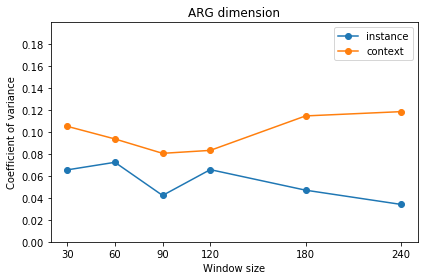

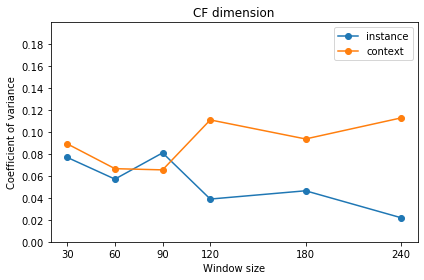

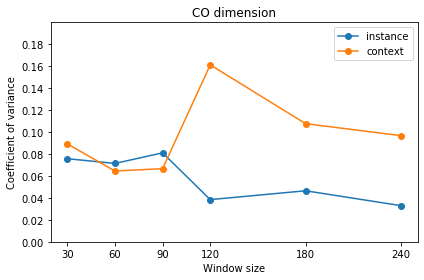

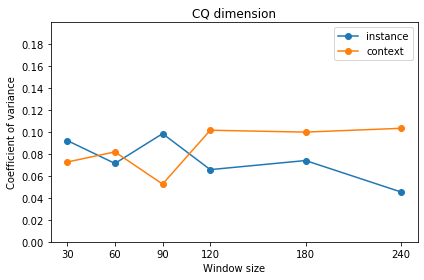

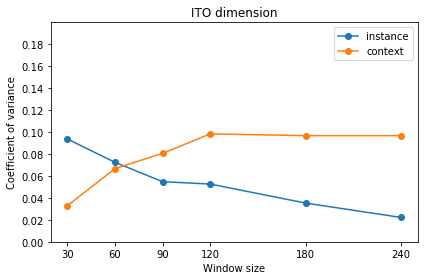

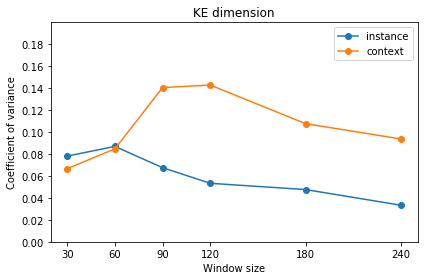

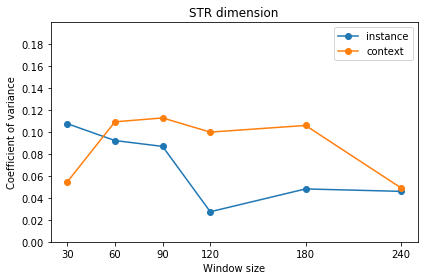

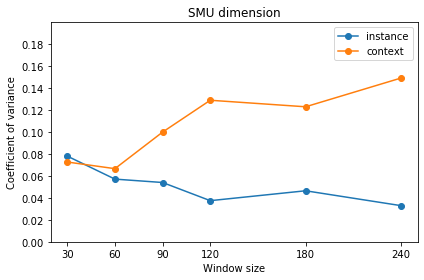

In [52]:
METRIC = 'auc'
windows = [30,60,90,120,180,240]

for dim in dimensions:
    win_df = df.loc[df['dimension']==dim,:]
    plt.figure()
    data1 = []
    data2 = []
    for window in windows:
        dim_df = win_df.loc[win_df['window'] == window,:]

        for level in ['instance','session']:
            level_df = dim_df.loc[dim_df['level'] == level,METRIC]
            val = list(level_df.to_dict().values())[0]
            
            

            avg = 100 * float((val).split('(')[0])
            std = 100 * float((val).split('(')[1].split(')')[0])
            if level == 'instance':
                data1.append(std/avg)
            else:
                data2.append(std/avg)
            #temp.append('{:.0f} ({:.0f})'.format(avg,std))
    plotTwoBar(windows,data1,data2)
    


## Plotting window-wise performance graph
Following code visualizes model's performance for each dimension on different window size. 

In [ ]:
df = pd.read_csv('random_forest_different_windows_91_98_99_sessions.csv')
df.columns

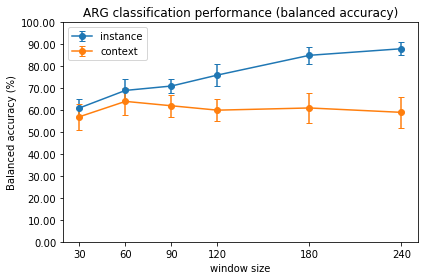

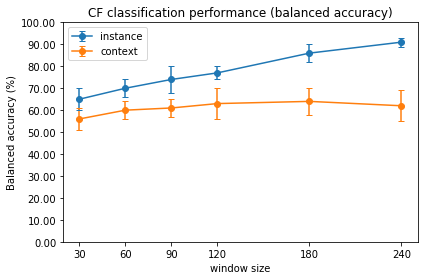

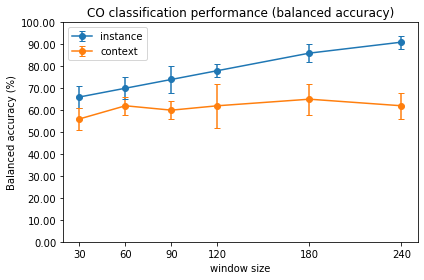

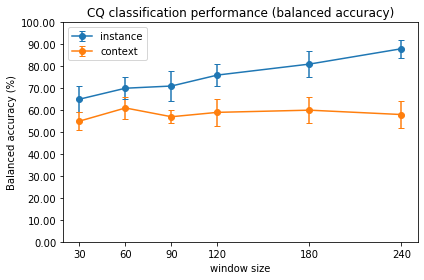

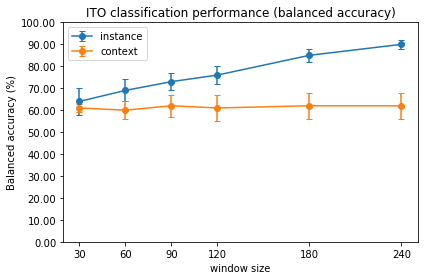

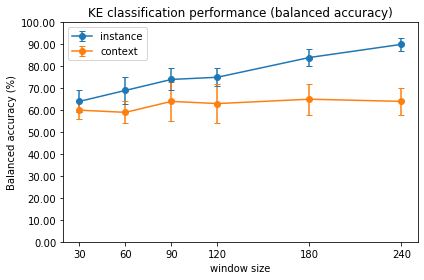

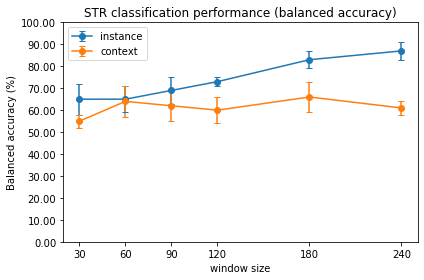

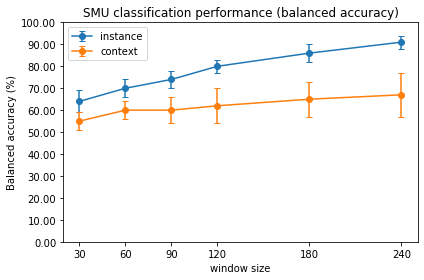

In [55]:

yticks = np.arange(0,1.1,.1)
yticks_labels=['{:.2f}'.format(item) for item in 100* yticks]

for dim in dimensions:
    arg_df = df.loc[df['dimension'] == dim,:]
    
    plt.figure()
    for level in ['instance','session']:
        arg_ins_df = arg_df.loc[arg_df['level'] == level,:]

        x = []
        y = []
        error= []
        for row in arg_ins_df.itertuples():
            x.append(row.window)
            y.append(float((row.accuracy2).split('(')[0]))
            error.append(float((row.accuracy2).split('(')[1].split(')')[0]))
    
        plt.xticks([30,60,90,120,180,240])
        plt.ylim([0,1])
        plt.errorbar(x,y,error,marker='o',capsize=3,label='context' if level=='session' else 'instance')
    label = '{} classification performance ({})'.format(dim,'balanced accuracy')
    figure_file = '{}_lak23_window_auc.png'.format(dim)
    plt.yticks(yticks,yticks_labels)

    plt.xlabel('window size')
    plt.ylabel('Balanced accuracy (%)')
    plt.title(label)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig(figure_file,format='png')
    plt.show()
